<a href="https://colab.research.google.com/github/Sentinel-FYP/colab_notebooks/blob/main/sentinel_data_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load video data

In [ ]:
import tqdm
import random
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

import os
import zipfile as zf
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
DATASET_DIR = '/content/drive/MyDrive/ucf_dataset'
zip_files = [file for file in os.listdir(DATASET_DIR) if file.endswith('zip')]
zip_files

['Anomaly-Videos-Part-1.zip',
 'Anomaly-Videos-Part-2.zip',
 'Anomaly-Videos-Part-3.zip',
 'Anomaly-Videos-Part-4.zip',
 'Normal_Videos_for_Event_Recognition.zip',
 'Testing_Normal_Videos.zip',
 'UCF_Crimes-Train-Test-Split.zip',
 'Training-Normal-Videos-Part-1.zip',
 'Training-Normal-Videos-Part-2.zip']

In [ ]:
def list_files_from_zip(zip_file):
  """ List the files in each class of the dataset given a zip file.

    Args:
      zip_file: zip file from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  with zf.ZipFile(zip_file) as zip:
    return [f for f in zip.namelist() if f.endswith('.mp4')]


def files_list_to_df(files):
  df = pd.DataFrame({'file_path': files})
  df['file_name'] = df['file_path'].apply(lambda x: x.split('/')[-1])
  df['zip_folder'] = df['file_path'].apply(lambda x: x.split('/')[0])
  df = df.set_index('file_name')
  return df

In [ ]:
def files_from_zips_list(zip_files):
  result = pd.DataFrame()
  for zf in zip_files:
    files = list_files_from_zip(os.path.join(DATASET_DIR, zf))
    df = files_list_to_df(files)
    result = pd.concat([result, df], axis=0)
  return result

In [ ]:
df = files_from_zips_list(zip_files)

In [ ]:
print(f"Total Videos: {df.shape[0]}")

Total Videos: 1950


In [ ]:
# load annotations
annotations = pd.read_csv(os.path.join(DATASET_DIR, 'frame_annotations.csv'))
annotations = annotations.set_index('file_name')
annotations['binary_class'] = annotations['is_annomaly'].map({1.0 : 'Anomaly', 0.0 : "Normal"})

In [ ]:
print(f'Total Annotated Videos: {annotations.shape[0]}')

Total Annotated Videos: 1900


In [ ]:
def merge_annotations_df(annotations, files_df):
  result = files_df.merge(annotations, left_index=True, right_index=True, how='inner')
  return result

In [ ]:
df = merge_annotations_df(annotations, df)
df = df.dropna()
print(f'Final Video Count: {df.shape[0]}')

Final Video Count: 1749


Begin with a few videos and a limited number of classes for training. After running the above code block, notice that the class name is included in the filename of each video.

Define the `get_class` function that retrieves the class name from a filename. Then, create a function called `get_files_per_class` which converts the list of all files (`files` above) into a dictionary listing the files for each class:

In [ ]:
def get_class(fname):
  """ Retrieve the name of the class given a filename/file_path.

    Args:
      fname: Name of the file in the UCF Crime dataset.
    Returns:
      Class that the file belongs to.
  """
  fname = fname.split('/')[-1]
  class_name = fname.split('_')[0]
  #remove numbers
  class_name = ''.join(char for char in class_name if not char.isnumeric())
  if class_name == "Normal":
    return "Normal"
  else:
    return "Anomaly"

In [ ]:
def get_files_per_column(annotations, column='binary_class', file_column=''):
  """ Retrieve the files that belong to each class.

    Args:
      annotations: pandas Dataframe of annotated frames
      column: column by which files are categorized
    Returns:
      Dictionary of class names (key) and files (values).
  """
  class_file_dict = {}
  # Iterate through unique class names
  for class_name in annotations[column].unique():
      # Filter the DataFrame for rows with the current class
      class_data = annotations[annotations[column] == class_name]
      # Extract the file names as a list
      if file_column == '':
        file_names = class_data.index.tolist()
      else:
        file_names = class_data[file_column].tolist()

      # Add the class name and file names to the dictionary
      class_file_dict[class_name] = file_names
  return class_file_dict

Once you have the list of files per class, you can choose how many classes you would like to use and how many videos you would like per class in order to create your dataset.

In [ ]:
FILES_PER_CLASS = 500

In [ ]:
files_for_class = get_files_per_column(df, column='binary_class')
classes = list(files_for_class.keys())


In [ ]:
NUM_CLASSES = len(classes)
print('Num classes:', len(classes))
print("Classes: ", classes)
print('Num videos for class[0]:', len(files_for_class[classes[0]]))
print('Num videos for class[1]:', len(files_for_class[classes[1]]))

Num classes: 2
Classes:  ['Anomaly', 'Normal']
Num videos for class[0]: 949
Num videos for class[1]: 800


Create a new function called `select_subset_of_classes` that selects a subset of the classes present within the dataset and a particular number of files per class:

In [ ]:
def select_subset_of_classes(df, max_records_per_class, column="binary_class"):
  return df.groupby(column).head(max_records_per_class)

In [ ]:
df = select_subset_of_classes(df, FILES_PER_CLASS, column='binary_class')
print("Number of videos in the subset: ", df.shape[0])

Number of videos in the subset:  1000


In [ ]:
def split_dataframe(df, train_percent=0.70, val_percent=0.15, test_percent=0.15, random_seed=None):
    """
    Splits a DataFrame into three DataFrames: train_df, val_df, and test_df.

    Args:
        df (pd.DataFrame): The main DataFrame to be split.
        train_percent (float): Percentage of data for training (default is 0.70).
        val_percent (float): Percentage of data for validation (default is 0.15).
        test_percent (float): Percentage of data for testing (default is 0.15).
        random_seed (int): Seed for random number generation (optional).

    Returns:
        tuple: A tuple containing three DataFrames (train_df, val_df, test_df).
    """
    if train_percent + val_percent + test_percent != 1.0:
        raise ValueError("The sum of train_percent, val_percent, and test_percent must equal 1.0.")

    # Split the data into train and temp datasets
    train_data, temp_data = train_test_split(df, train_size=train_percent, random_state=random_seed)
    if val_percent == 0:
      return train_data, temp_data
    # Calculate the effective percentage for validation and testing
    remaining_percent = 1.0 - train_percent
    val_percent_of_remaining = val_percent / remaining_percent
    test_percent_of_remaining = test_percent / remaining_percent

    # Split the temp data into validation and test datasets
    val_data, test_data = train_test_split(temp_data, train_size=val_percent_of_remaining, random_state=random_seed)

    return train_data, val_data, test_data


In [ ]:
train_df, test_df = split_dataframe(df, train_percent=0.85, val_percent=0, test_percent=0.15)
print("Number of Training Videos: ", train_df.shape[0])
print("Number of Test Videos: ", test_df.shape[0])

Number of Training Videos:  850
Number of Test Videos:  150


Text(0.5, 1.0, 'Class Distribution in Train Set')

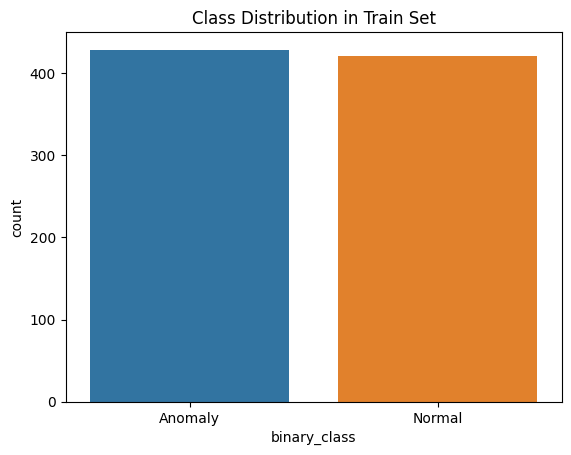

In [ ]:
sns.countplot(train_df, x='binary_class')
plt.title('Class Distribution in Train Set')



Text(0.5, 1.0, 'Class Distribution in Test Set')

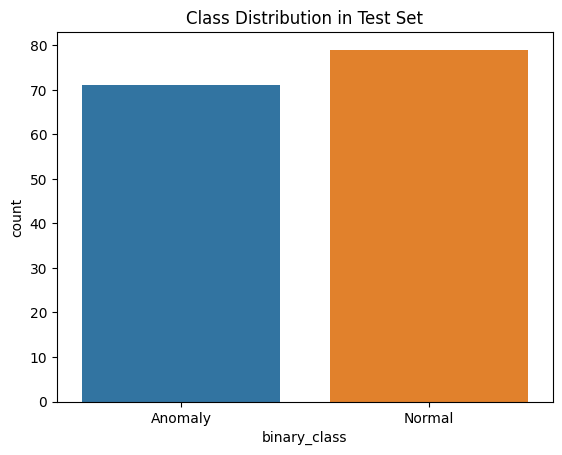

In [ ]:
sns.countplot(test_df, x='binary_class')
plt.title('Class Distribution in Test Set')

In [ ]:
def extract_from_zip(zip_file, to_dir, file_names):
  with zf.ZipFile(zip_file) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn
      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

def remove_empty_folders(target_directory):
    for root, dirs, files in os.walk(target_directory, topdown=False):
      for directory in dirs:
          directory_path = os.path.join(root, directory)
          if not os.listdir(directory_path):
              os.rmdir(directory_path)

In [ ]:
def extract_from_df(df, output_dir):
  files_per_zip = get_files_per_column(df, column='zip_folder', file_column='file_path')
  for zip_file, file_names in files_per_zip.items():
    extract_from_zip(os.path.join(DATASET_DIR, zip_file + ".zip"), output_dir, file_names)
  remove_empty_folders(str(output_dir))

In [ ]:
output_dir = pathlib.Path('/content/drive/MyDrive/ucf_extracted')
paths = {}
paths['train'] = output_dir / 'train'
paths['val'] = output_dir / 'val'
paths['test'] = output_dir / 'test'


In [ ]:
!rm -r /content/drive/MyDrive/ucf_extracted

rm: cannot remove '/content/drive/MyDrive/ucf_extracted': No such file or directory


In [ ]:
extract_from_df(train_df, paths['train'])
extract_from_df(test_df, paths['test'])

100%|██████████| 12/12 [01:44<00:00,  8.69s/it]


After downloading the data, you should now have a copy of a subset of the UCF101 dataset. Run the following code to print the total number of videos you have amongst all your subsets of data.

In [ ]:
video_count_train = len(list(output_dir.glob('train/*/*.mp4')))
video_count_val = len(list(output_dir.glob('val/*/*.mp4')))
video_count_test = len(list(output_dir.glob('test/*/*.mp4')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 0


You can also preview the directory of data files now.

In [ ]:
!find /content/drive/MyDrive/ucf_extracted

/drive/MyDrive/ucf_extracted
/drive/MyDrive/ucf_extracted/test
/drive/MyDrive/ucf_extracted/test/Anomaly
/drive/MyDrive/ucf_extracted/test/Anomaly/Assault004_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/Arson030_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/Assault012_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/Assault005_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/Abuse017_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/RoadAccidents087_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/Arrest010_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/Abuse046_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/RoadAccidents075_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/RoadAccidents015_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/RoadAccidents078_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/Abuse016_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/Burglary088_x264.mp4
/drive/MyDrive/ucf_extracted/test/Anomaly/RoadAccidents083_x264.mp4
/driv